# Exploratory Data Analysis
#### Pre_normalized dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
# Read the preprocessed data
import os

file_path = os.path.join('data', 'csvs', 'pre_normalized.csv')
df = pd.read_csv(file_path)
df.head()

,text,label
0,autor bestseller cita 5 expressoes indicam int...,fake
1,juiz df confirma indicios expresidente petista...,fake
2,senhora 60 anos corre atras eduardo cunha aero...,fake
3,russia ameaca derrubar avioes americanos siria...,fake
4,governo podera demitir 18 mil servidores banco...,fake


In [3]:
# Split into fake and true news
fake_df = df[df["label"] == 'fake']
true_df = df[df["label"] == 'true']

In [4]:
# Create bag of words for each df
from sklearn.feature_extraction.text import CountVectorizer

fake_bag = CountVectorizer().fit(fake_df["text"])
true_bag = CountVectorizer().fit(true_df["text"])


In [5]:
fake_cv = CountVectorizer()
fake_matrix = fake_cv.fit_transform(fake_df["text"])
fake_bag = {}
for word in fake_cv.get_feature_names_out(): 
    fake_bag[word] = fake_matrix[:, fake_cv.vocabulary_[word]].sum()


In [6]:
true_cv = CountVectorizer()
true_matrix = true_cv.fit_transform(true_df["text"])
true_bag = {}
for word in true_cv.get_feature_names_out(): 
    true_bag[word] = true_matrix[:, true_cv.vocabulary_[word]].sum()

In [7]:
# Create a bag of words with the difference between the two

# Get all words from both bags
all_words = set(list(fake_bag.keys()) + list(true_bag.keys()))

bag = {}
for word in all_words:
    if word in fake_bag and word in true_bag:
        bag[word] = true_bag[word] - fake_bag[word]
    elif word in fake_bag:
        bag[word] = -fake_bag[word]
    else:
        bag[word] = true_bag[word]

In [8]:
# Create a bag of words with the difference between the two

# Get all words from both bags
all_words = set(list(fake_bag.keys()) + list(true_bag.keys()))

bag = {}
for word in all_words:
    if word in fake_bag and word in true_bag:
        bag[word] = true_bag[word] - fake_bag[word]
    elif word in fake_bag:
        bag[word] = -fake_bag[word]
    else:
        bag[word] = true_bag[word]


In [9]:
worst_to_best = sorted(bag.items(), key= lambda x: x[1])

print(f"worst word: {worst_to_best[:5]}")
print(f"best word: {worst_to_best[-5:]}")

worst word: [('dilma', -1291), ('lula', -1081), ('disse', -1053), ('video', -502), ('brasil', -418)]
best word: [('lava', 648), ('segundo', 657), ('tribunal', 758), ('federal', 973), ('nesta', 1421)]


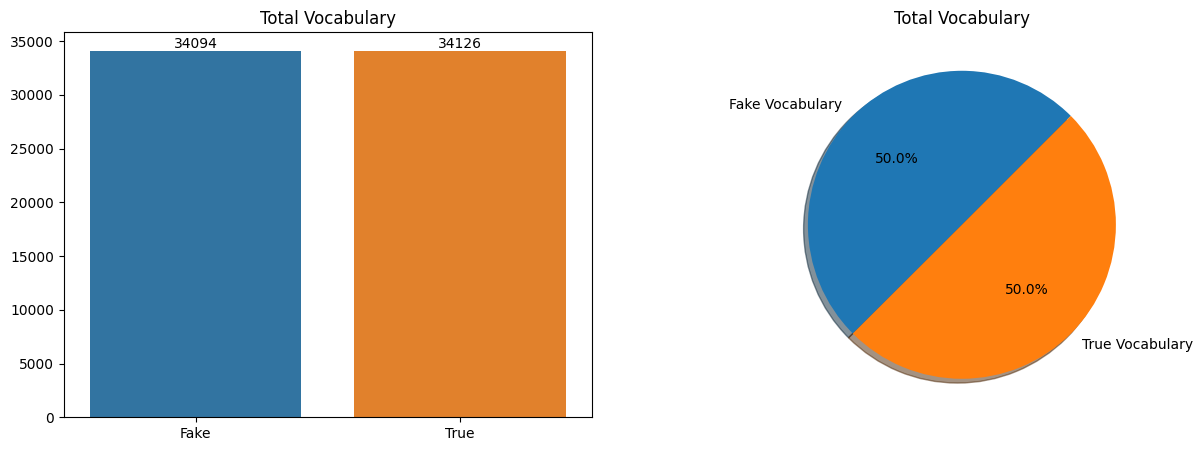

In [10]:
# Total vacubulary for each bag
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.ravel()
sns.barplot(x=["Fake", "True"], y=[len(fake_bag), len(true_bag)], ax = axes[0])
axes[0].bar_label(axes[0].containers[0], label_type='edge', fmt='%d', color='black')
axes[0].title.set_text("Total Vocabulary")


axes[1].pie([len(fake_bag), len(true_bag)], labels=["Fake Vocabulary", "True Vocabulary"], autopct='%1.1f%%', shadow=True, startangle= 45)
axes[1].title.set_text("Total Vocabulary")

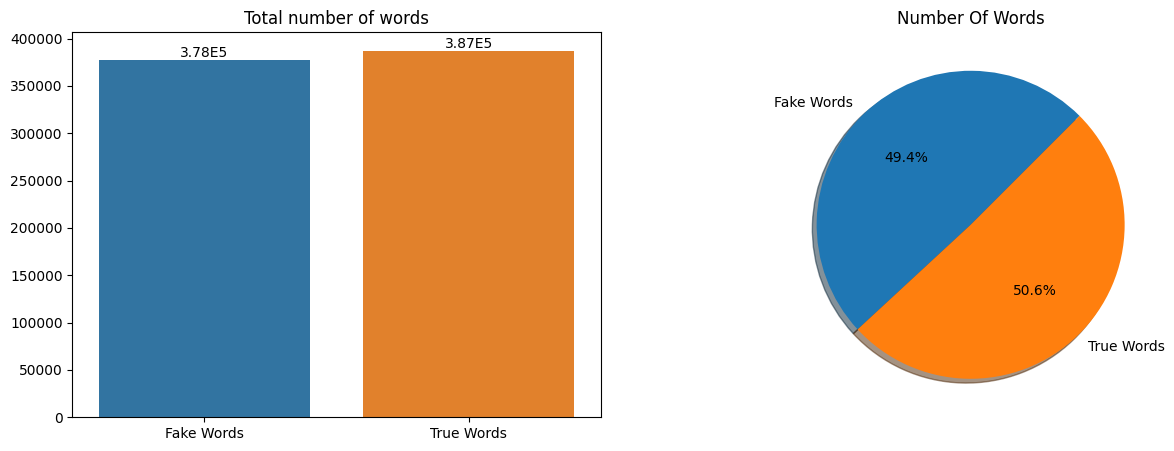

In [11]:
numberOfFakeWords = sum(fake_bag.values())
numberOfTrueWords = sum(true_bag.values())
numberOfWords = numberOfFakeWords + numberOfTrueWords

def my_fmt(x):
    return f"{x/10**5:.2f}E5"

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.ravel()
sns.barplot(x=["Fake Words", "True Words"], y=[numberOfFakeWords, numberOfTrueWords], ax = axes[0])
axes[0].bar_label(axes[0].containers[0], label_type='edge', fmt= my_fmt, color='black')
axes[0].title.set_text("Total number of words")


axes[1].pie([numberOfFakeWords, numberOfTrueWords], labels=["Fake Words", "True Words"], autopct='%1.1f%%', shadow=True, startangle= 45)
axes[1].title.set_text("Number Of Words")

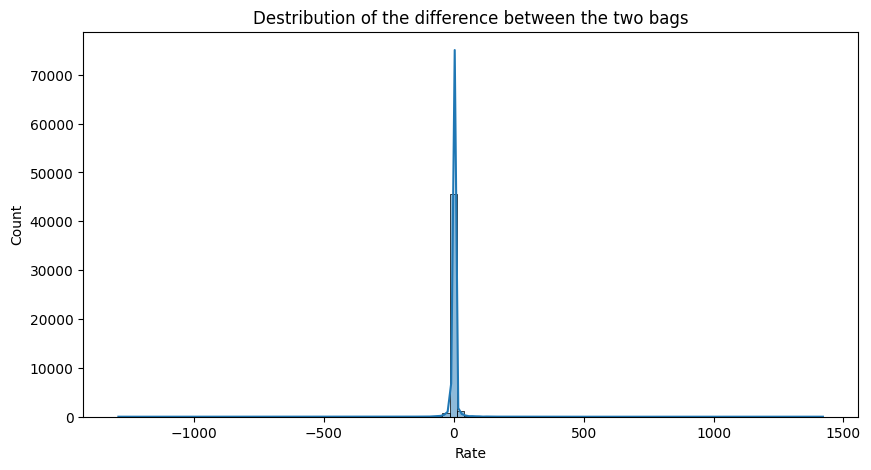

In [15]:
distribution_df = pd.DataFrame(bag.values(), columns=["Rate"])
distribution_df

# Create a histogram of the distribution
plt.figure(figsize=(10,5))
sns.histplot(distribution_df["Rate"], bins=100, kde=True)
plt.title("Distribution of the difference between the two bags")
plt.show()

Most of words have 0 near rate (present in fake and true)

In [17]:
normalized_fake_bag = {}
for word in fake_bag:
    normalized_fake_bag[word] = fake_bag[word] / numberOfFakeWords

normalized_true_bag = {}
for word in true_bag:
    normalized_true_bag[word] = true_bag[word] / numberOfTrueWords

normalized_bag = {}
for word in all_words:
    if word in normalized_fake_bag and word in normalized_true_bag:
        normalized_bag[word] = normalized_true_bag[word] - normalized_fake_bag[word]
    elif word in fake_bag:
        normalized_bag[word] = -normalized_fake_bag[word]
    else:
        normalized_bag[word] = normalized_true_bag[word]

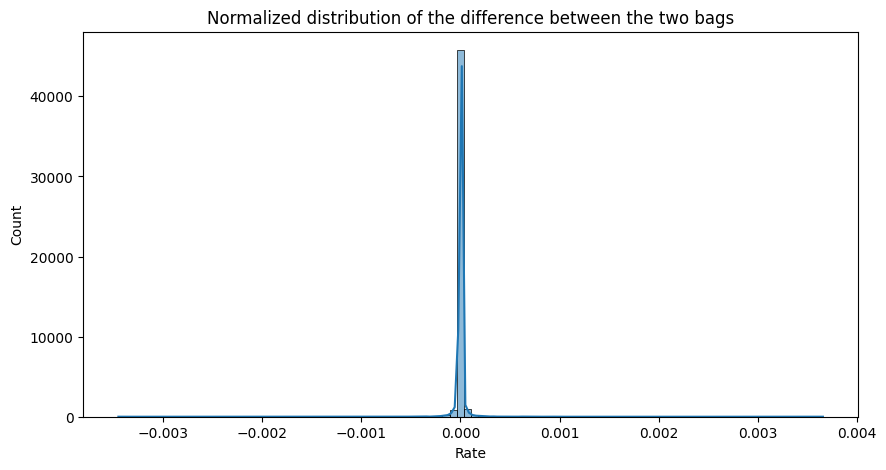

In [18]:
normalized_distribution_df = pd.DataFrame(normalized_bag.items(), columns=["Word", "Rate"])

# Create a histogram of the distribution
plt.figure(figsize=(10,5))
sns.histplot(normalized_distribution_df["Rate"], bins=100, kde=True)
plt.title("Normalized distribution of the difference between the two bags")
plt.show()

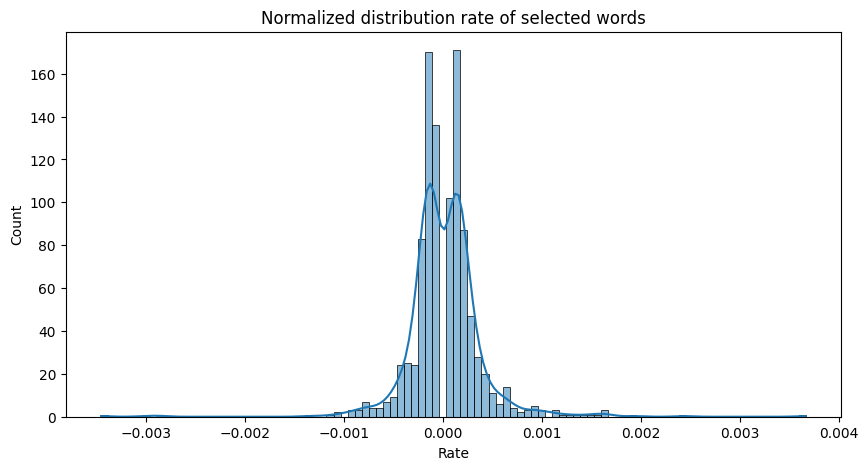

In [22]:
top_values = 1024

# only keep 1% words with greatest rate in absolute value
selected_distribution_df = normalized_distribution_df\
                           .sort_values(by="Rate", key=abs, ascending=False)\
                           .head(top_values)

# Create a histogram of the distribution
plt.figure(figsize=(10,5))
sns.histplot(selected_distribution_df["Rate"], bins=100, kde=True)
plt.title("Normalized distribution rate of selected words")
plt.show()

In [24]:
i = 0
filtered_vocab = {}
for word in selected_distribution_df["Word"]:
    # if word.isnumeric():
    #     continue
    filtered_vocab[word] = i
    i += 1

In [ ]:
# save filtered vocabulary to csv
with open('data/vocabularies/filtered_vocab_'+str(top_values)+'.csv', 'w') as f:
    f.write("word,index\n")
    for key in filtered_vocab.keys():
        f.write("%s,%d\n" % (key, filtered_vocab[key]))

In [20]:
numberOfNegativeWords = len(selected_distribution_df[selected_distribution_df["Rate"] < 0])
numberOfPositiveWords = len(selected_distribution_df[selected_distribution_df["Rate"] > 0])

print(f"Number of negative words: {numberOfNegativeWords}")
print(f"Number of positive words: {numberOfPositiveWords}")

bag_filtered = CountVectorizer(vocabulary=filtered_vocab)
print(f"Total number of words in the vocabulary: {len(filtered_vocab)}")
print(filtered_vocab.keys())


Number of negative words: 115
Number of positive words: 141
Total number of words in the vocabulary: 256
dict_keys(['nesta', 'dilma', 'lula', 'disse', 'federal', 'tribunal', 'segundo', 'lava', 'jato', 'ano', '2017', 'anos', 'video', 'diz', 'quartafeira', 'sobre', 'brasil', 'rio', 'tercafeira', 'desta', 'hoje', 'lavajato', 'decisao', 'quintafeira', 'g1', 'globo', 'pt', 'luiz', 'eldorado', 'supremo', 'segundafeira', 'jornalista', 'apos', 'acordo', 'tudo', 'sextafeira', 'regiao', 'pra', 'temer', 'petista', 'moro', 'atraves', 'povo', 'pais', 'dia', 'impeachment', 'durante', 'operacao', 'informou', 'podera', 'primeira', 'julgamento', 'tres', 'silva', 'sergio', 'cunha', 'redes', 'justica', 'ouvir', 'janeiro', 'noite', 'presidente', 'principais', 'afirmou', 'vai', 'eua', 'inacio', 'denuncia', 'sociais', 'expresidente', 'desde', 'estados', 'ministerio', 'camara', 'pedido', 'defesa', 'deputado', 'sendo', 'informacoes', 'bolsonaro', 'porque', 'materia', 'clique', '2018', 'reforma', 'site', 'dois